<a href="https://colab.research.google.com/github/dannner66/Szakdoga/blob/main/train_schedule_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder #sklearn

from xgboost import XGBRegressor #xgboost
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt #matplotlib
from xgboost import plot_tree
import xgboost as xgb

from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import KFold
import numpy as np #numpy
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import make_pipeline


# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [109]:
pd.set_option('display.max_columns',120)
pd.set_option('display.max_rows',120)

In [110]:
dataset = pd.read_excel('/content/sample.xlsx')
dataset.head()

,train_id,terv_date,terv_ind,terv_erk,ind_stat_terv,ind_nev_terv,erk_stat_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_stat_teny,ind_teny,erk_stat_teny,erk_teny
0,79877,2021-04-11 02:00:00,1970-01-01 11:00:00,1970-01-01 11:09:00,13771,Szajol,13748,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,13771,Szajol,13748,Szolnok
1,102865,2021-09-21 00:00:00,1970-01-01 18:00:00,1970-01-01 18:52:00,10074,Rákos,1081,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,10074,Rákos,1081,Bicske
2,93885,2021-07-23 02:00:00,1970-01-01 23:00:00,1970-01-01 23:16:00,13847,Karcag,13862,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,13847,Karcag,13862,Püspökladány
3,119226,2021-12-19 00:00:00,1970-01-01 10:00:00,1970-01-01 16:14:00,13722,Cegléd,13821,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,13722,Cegléd,13821,Kisújszállás
4,125506,2022-01-30 00:00:00,1970-01-01 17:30:00,1970-01-01 21:26:00,3285,Szabadbattyán,4648,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,3285,Szabadbattyán,4648,Uzsabánya


In [111]:
dataset['train_id'] = dataset['train_id'].astype(str)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   train_id       200 non-null    object
 1   terv_date      200 non-null    object
 2   terv_ind       200 non-null    object
 3   terv_erk       200 non-null    object
 4   ind_stat_terv  200 non-null    int64 
 5   ind_nev_terv   200 non-null    object
 6   erk_stat_terv  200 non-null    int64 
 7   erk__terv      200 non-null    object
 8   teny_ind       200 non-null    object
 9   teny_erk       200 non-null    object
 10  rakom_tom      200 non-null    int64 
 11  vonathossz     200 non-null    int64 
 12  vontat_mode    91 non-null     object
 13  vonatnem       200 non-null    object
 14  ind_stat_teny  200 non-null    int64 
 15  ind_teny       200 non-null    object
 16  erk_stat_teny  200 non-null    int64 
 17  erk_teny       200 non-null    object
dtypes: int64(6), object(12)
memory

In [112]:
#print(dataset['terv_ind'])
def concat_terv(data):

  for idx, row in data.iterrows():
        tmp_date = str(data.at[idx, 'terv_date']).split(" ")[0] + ' ' + str(data.at[idx, 'terv_ind']).split(" ")[1]
        data.at[idx, 'terv_ind'] = pd.to_datetime(tmp_date)
        tmp_date = str(data.at[idx, 'terv_date']).split(" ")[0] + ' ' + str(data.at[idx, 'terv_erk']).split(" ")[1]
        data.at[idx, 'terv_erk'] = pd.to_datetime(tmp_date)
  return data

In [113]:
concat_terv(dataset)

,train_id,terv_date,terv_ind,terv_erk,ind_stat_terv,ind_nev_terv,erk_stat_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_stat_teny,ind_teny,erk_stat_teny,erk_teny
0,79877,2021-04-11 02:00:00,2021-04-11 11:00:00,2021-04-11 11:09:00,13771,Szajol,13748,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,13771,Szajol,13748,Szolnok
1,102865,2021-09-21 00:00:00,2021-09-21 18:00:00,2021-09-21 18:52:00,10074,Rákos,1081,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,10074,Rákos,1081,Bicske
2,93885,2021-07-23 02:00:00,2021-07-23 23:00:00,2021-07-23 23:16:00,13847,Karcag,13862,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,13847,Karcag,13862,Püspökladány
3,119226,2021-12-19 00:00:00,2021-12-19 10:00:00,2021-12-19 16:14:00,13722,Cegléd,13821,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,13722,Cegléd,13821,Kisújszállás
4,125506,2022-01-30 00:00:00,2022-01-30 17:30:00,2022-01-30 21:26:00,3285,Szabadbattyán,4648,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,3285,Szabadbattyán,4648,Uzsabánya
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,207788,2023-06-29 00:00:00,2023-06-29 11:00:00,2023-06-29 11:30:00,11445,Szerencs,13284,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,11445,Szerencs,13284,Tállya
196,209006,2023-07-15 00:00:00,2023-07-15 16:17:00,2023-07-15 16:57:00,17137,Kiskunfélegyháza,16311,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,17137,Kiskunfélegyháza,16311,Kiskunhalas
197,223395,2023-12-15 00:00:00,2023-12-15 01:00:00,2023-12-15 01:26:00,10025,Ferencváros,10082,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,10025,Ferencváros,10082,Rákosrendező
198,227451,2024-02-13 00:00:00,2024-02-13 16:00:00,2024-02-13 16:55:00,11395,Felsőzsolca,11296,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,11395,Felsőzsolca,11296,Füzesabony


In [114]:
dataset.drop('ind_stat_teny', axis=1, inplace=True)
dataset.drop('ind_stat_terv', axis=1, inplace=True)
dataset.drop('erk_stat_teny', axis=1, inplace=True)
dataset.drop('erk_stat_terv', axis=1, inplace=True)
dataset.drop('terv_date', axis=1, inplace=True)
dataset.drop('train_id', axis=1, inplace=True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   terv_ind      200 non-null    object
 1   terv_erk      200 non-null    object
 2   ind_nev_terv  200 non-null    object
 3   erk__terv     200 non-null    object
 4   teny_ind      200 non-null    object
 5   teny_erk      200 non-null    object
 6   rakom_tom     200 non-null    int64 
 7   vonathossz    200 non-null    int64 
 8   vontat_mode   91 non-null     object
 9   vonatnem      200 non-null    object
 10  ind_teny      200 non-null    object
 11  erk_teny      200 non-null    object
dtypes: int64(2), object(10)
memory usage: 18.9+ KB


In [115]:
dataset[dataset['terv_ind'] == dataset['terv_erk']]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny


In [116]:
dataset = dataset[dataset['teny_ind'] != dataset['teny_erk']].copy()

In [117]:


def extract_date(data):

    data['terv_ind'] = pd.to_datetime(data['terv_ind'],format="%Y-%m-%d %H:%M:%S")
    data['terv_ind_Year'] = data.terv_ind.dt.year
    data['terv_ind_Month'] = data.terv_ind.dt.month
    data['terv_ind_Day'] = data.terv_ind.dt.day
    data['terv_ind_Hour'] = data.terv_ind.dt.hour
    data['terv_ind_Minute'] = data.terv_ind.dt.minute
    data['terv_ind_Second'] = data.terv_ind.dt.second
    data['terv_ind_WeekOfYear'] = data.terv_ind.dt.isocalendar().week

    data['terv_erk'] = pd.to_datetime(data['terv_erk'],format="%Y-%m-%d %H:%M:%S")
    data['terv_erk_Year'] = data.terv_erk.dt.year
    data['terv_erk_Month'] = data.terv_erk.dt.month
    data['terv_erk_Day'] = data.terv_erk.dt.day
    data['terv_erk_Hour'] = data.terv_erk.dt.hour
    data['terv_erk_Minute'] = data.terv_erk.dt.minute
    data['terv_erk_Second'] = data.terv_erk.dt.second
    data['terv_erk_WeekOfYear'] = data.terv_erk.dt.isocalendar().week

    data['teny_ind'] = pd.to_datetime(data['teny_ind'],format="%Y-%m-%d %H:%M:%S")
    data['teny_ind_Year'] = data.teny_ind.dt.year
    data['teny_ind_Month'] = data.teny_ind.dt.month
    data['teny_ind_Day'] = data.teny_ind.dt.day
    data['teny_ind_Hour'] = data.teny_ind.dt.hour
    data['teny_ind_Minute'] = data.teny_ind.dt.minute
    data['teny_ind_Second'] = data.teny_ind.dt.second
    data['teny_ind_WeekOfYear'] = data.teny_ind.dt.isocalendar().week

    data['teny_erk'] = pd.to_datetime(data['teny_erk'],format="%Y-%m-%d %H:%M:%S")
    data['teny_erk_Year'] = data.teny_erk.dt.year
    data['teny_erk_Month'] = data.teny_erk.dt.month
    data['teny_erk_Day'] = data.teny_erk.dt.day
    data['teny_erk_Hour'] = data.teny_erk.dt.hour
    data['teny_erk_Minute'] = data.teny_erk.dt.minute
    data['teny_erk_Second'] = data.teny_erk.dt.second
    data['teny_erk_WeekOfYear'] = data.teny_erk.dt.isocalendar().week
    #data.drop('terv_ind', axis=1, inplace=True)
    #data.drop('terv_erk', axis=1, inplace=True)
    #data.drop('teny_ind', axis=1, inplace=True)
    #data.drop('teny_erk', axis=1, inplace=True)
    #data.drop('terv_date', axis=1, inplace=True)

In [118]:
extract_date(dataset)

In [119]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   terv_ind             200 non-null    datetime64[ns]
 1   terv_erk             200 non-null    datetime64[ns]
 2   ind_nev_terv         200 non-null    object        
 3   erk__terv            200 non-null    object        
 4   teny_ind             200 non-null    datetime64[ns]
 5   teny_erk             200 non-null    datetime64[ns]
 6   rakom_tom            200 non-null    int64         
 7   vonathossz           200 non-null    int64         
 8   vontat_mode          91 non-null     object        
 9   vonatnem             200 non-null    object        
 10  ind_teny             200 non-null    object        
 11  erk_teny             200 non-null    object        
 12  terv_ind_Year        200 non-null    int32         
 13  terv_ind_Month       200 non-null  

In [120]:
dataset = dataset[dataset.rakom_tom >= 0].copy()
dataset = dataset[dataset.vonathossz >= 0].copy()

dataset[dataset.terv_erk == ""]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear


In [121]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   terv_ind             200 non-null    datetime64[ns]
 1   terv_erk             200 non-null    datetime64[ns]
 2   ind_nev_terv         200 non-null    object        
 3   erk__terv            200 non-null    object        
 4   teny_ind             200 non-null    datetime64[ns]
 5   teny_erk             200 non-null    datetime64[ns]
 6   rakom_tom            200 non-null    int64         
 7   vonathossz           200 non-null    int64         
 8   vontat_mode          91 non-null     object        
 9   vonatnem             200 non-null    object        
 10  ind_teny             200 non-null    object        
 11  erk_teny             200 non-null    object        
 12  terv_ind_Year        200 non-null    int32         
 13  terv_ind_Month       200 non-null  

In [122]:
def duration(data):
    # Calculate the timedeltas
    travel_time_terv = data['terv_erk'] - data['terv_ind']
    travel_time_teny = data['teny_erk'] - data['teny_ind']

    # Calculate days, hours, and minutes for terv
    data['travel_time_terv'] = (travel_time_terv.dt.seconds // 3600)*60 + (travel_time_terv.dt.seconds % 3600) // 60
    # Calculate days, hours, and minutes for teny (if needed)
    data['travel_time_teny'] = (travel_time_teny.dt.seconds // 3600)*60 + (travel_time_teny.dt.seconds % 3600) // 60
    return data


In [123]:
import datetime
def arrival_repair(data):

    tmp_str_date = ''
    for idx, row in data.iterrows():
        if row['terv_erk'] <= row['terv_ind']:
            data.at[idx, 'terv_erk'] += datetime.timedelta(days=1)
        tmp_str_date = str(data.at[idx,'terv_erk_Year']) +'-'+ str(data.at[idx,'terv_erk_Month']) + '-' + str(data.at[idx,'terv_erk_Day']) + ' ' + str(data.at[idx,'terv_erk_Hour']) + ':' + str(data.at[idx,'terv_erk_Minute']) + ':' + str(data.at[idx,'terv_erk_Second'])
        data.at[idx,  'terv_erk'] = pd.to_datetime(tmp_str_date,dayfirst=True)
        if row['teny_erk'] <= row['teny_ind']:
            data.at[idx, 'teny_erk'] += datetime.timedelta(days=1)
        tmp_str_date = str(data.at[idx,'teny_erk_Year']) +'-'+ str(data.at[idx,'teny_erk_Month']) + '-' + str(data.at[idx,'teny_erk_Day']) + ' ' + str(data.at[idx,'teny_erk_Hour']) + ':' + str(data.at[idx,'teny_erk_Minute']) + ':' + str(data.at[idx,'teny_erk_Second'])
        data.at[idx,  'teny_erk'] = pd.to_datetime(tmp_str_date, dayfirst=True)

    return data

In [124]:
dataset

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
0,2021-04-11 11:00:00,2021-04-11 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7


In [125]:
dataset_min_change = dataset.copy()
arrival_repair(dataset)

<ipython-input-123-50dd1000db31>:9: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data.at[idx,  'terv_erk'] = pd.to_datetime(tmp_str_date,dayfirst=True)
<ipython-input-123-50dd1000db31>:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data.at[idx,  'teny_erk'] = pd.to_datetime(tmp_str_date, dayfirst=True)


,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
0,2021-04-11 11:00:00,2021-11-04 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-11-04 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7


In [126]:
duration(dataset)

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny
0,2021-04-11 11:00:00,2021-11-04 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-11-04 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14,9,1430
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38,52,399
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29,16,1394
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51,374,954
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5,236,1189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26,30,54
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28,40,85
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50,26,73
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7,55,98


In [127]:
dataset = dataset[dataset.travel_time_teny > 5].copy()
dataset = dataset[dataset.travel_time_terv > 5].copy()

In [128]:
dataset[dataset.travel_time_teny < 0]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny


In [129]:
dataset[dataset.travel_time_terv <= 0]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny


In [130]:
dataset['rakom_tom'] = dataset['rakom_tom'].astype(int)
dataset['vonathossz'] = dataset['vonathossz'].astype(int)
dataset

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny
0,2021-04-11 11:00:00,2021-11-04 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-11-04 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14,9,1430
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38,52,399
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29,16,1394
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51,374,954
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5,236,1189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26,30,54
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28,40,85
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50,26,73
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7,55,98


In [131]:
dataset.columns

Index(['terv_ind', 'terv_erk', 'ind_nev_terv', 'erk__terv', 'teny_ind',
       'teny_erk', 'rakom_tom', 'vonathossz', 'vontat_mode', 'vonatnem',
       'ind_teny', 'erk_teny', 'terv_ind_Year', 'terv_ind_Month',
       'terv_ind_Day', 'terv_ind_Hour', 'terv_ind_Minute', 'terv_ind_Second',
       'terv_ind_WeekOfYear', 'terv_erk_Year', 'terv_erk_Month',
       'terv_erk_Day', 'terv_erk_Hour', 'terv_erk_Minute', 'terv_erk_Second',
       'terv_erk_WeekOfYear', 'teny_ind_Year', 'teny_ind_Month',
       'teny_ind_Day', 'teny_ind_Hour', 'teny_ind_Minute', 'teny_ind_Second',
       'teny_ind_WeekOfYear', 'teny_erk_Year', 'teny_erk_Month',
       'teny_erk_Day', 'teny_erk_Hour', 'teny_erk_Minute', 'teny_erk_Second',
       'teny_erk_WeekOfYear', 'travel_time_terv', 'travel_time_teny'],
      dtype='object')

In [132]:
input_cols = ['ind_nev_terv', 'rakom_tom',
       'vonathossz', 'vontat_mode', 'vonatnem', 'ind_teny', 'erk_teny',
       'terv_ind_Year', 'terv_ind_Month', 'terv_ind_Day', 'terv_ind_Hour',
       'terv_ind_Minute', 'terv_ind_Second', 'terv_ind_WeekOfYear',
       'terv_erk_Year', 'terv_erk_Month', 'terv_erk_Day', 'terv_erk_Hour',
       'terv_erk_Minute', 'terv_erk_Second', 'terv_erk_WeekOfYear',
       'teny_ind_Year', 'teny_ind_Month', 'teny_ind_Day', 'teny_ind_Hour',
       'teny_ind_Minute', 'teny_ind_Second', 'teny_ind_WeekOfYear',
       'teny_erk_Year', 'teny_erk_Month', 'teny_erk_Day', 'teny_erk_Hour',
       'teny_erk_Minute', 'teny_erk_Second', 'teny_erk_WeekOfYear',
       'travel_time_terv']
target_col = ['travel_time_teny']

In [133]:
x = dataset[input_cols].copy()
y = dataset[target_col].copy()

In [134]:

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30)
inputs = x_train
targets = y_train
test_inputs = x_test
test_inputs

,ind_nev_terv,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv
132,Ferencv.Nyugati.r.,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,11,27,22,30,0,47,2022,11,27,22,49,0,47,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19
129,Ferencv.Nyugati.r.,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,11,6,22,30,0,44,2022,11,6,22,49,0,44,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19
121,Ferencv.Nyugati.r.,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,9,11,22,30,0,36,2022,9,11,22,49,0,36,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19
53,Gyoma,0,18,NaN,M,Gyoma,Szeged-Rendező,2022,9,9,19,0,0,36,2022,9,9,21,34,0,36,2022,9,9,21,55,0,36,2022,9,10,14,34,0,36,154
183,Diósgyőr-Vasgyár,464840,124,NaN,T,Diósgyőr-Vasgyár,Miskolc-Rendező,2024,4,15,14,0,0,16,2024,4,15,14,12,0,16,2024,4,15,12,46,0,16,2024,4,15,13,32,0,16,12
0,Szajol,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14,9
34,Szeged-Rendező,0,18,NaN,M,Szeged-Rendező,Szolnok-Rendező,2023,8,13,22,0,0,32,2023,8,13,23,48,0,32,2023,8,14,1,26,0,33,2023,8,14,11,41,0,33,108
97,Bicske,343000,223,NaN,T,Bicske,Szárliget,2023,9,22,20,45,0,38,2023,9,22,20,56,0,38,2023,9,22,22,18,0,38,2023,9,23,6,38,0,38,11
92,Rákosrendező,0,20,tmElectric,M,Rákosrendező,Ferencváros,2023,12,6,20,0,0,49,2023,12,6,20,28,0,49,2023,12,6,21,11,0,49,2023,12,7,14,23,0,49,28
15,Szolnok-Rendező,0,20,NaN,M,Szolnok-Rendező,Dombóvár,2023,10,20,1,0,0,42,2023,10,20,4,28,0,42,2023,10,19,22,30,0,42,2023,10,20,13,20,0,42,208


In [135]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(140, 36)
(60, 36)
(140, 1)
(60, 1)


In [136]:
numeric_cols = ['rakom_tom','vonathossz',
       'terv_ind_Year', 'terv_ind_Month', 'terv_ind_Day', 'terv_ind_Hour',
       'terv_ind_Minute', 'terv_ind_Second', 'terv_ind_WeekOfYear',
       'terv_erk_Year', 'terv_erk_Month', 'terv_erk_Day', 'terv_erk_Hour',
       'terv_erk_Minute', 'terv_erk_Second', 'terv_erk_WeekOfYear',
       'teny_ind_Year', 'teny_ind_Month', 'teny_ind_Day', 'teny_ind_Hour',
       'teny_ind_Minute', 'teny_ind_Second', 'teny_ind_WeekOfYear',
       'teny_erk_Year', 'teny_erk_Month', 'teny_erk_Day', 'teny_erk_Hour',
       'teny_erk_Minute', 'teny_erk_Second', 'teny_erk_WeekOfYear',
       'travel_time_terv']
categorical_cols = ['ind_nev_terv', 'vontat_mode', 'vonatnem','ind_teny','erk_teny']

**Adatelemzés**

In [137]:
data_analysis = dataset

In [138]:
data_analysisNum = data_analysis[numeric_cols]

In [139]:
#Leíró statisztika
data_analysisNum.describe()

,rakom_tom,vonathossz,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv
count,2.000000e+02,200.000000,200.0000,200.000000,200.000000,200.000000,200.00000,200.0,200.0,200.0000,200.000000,200.000000,200.000000,200.000000,200.0,200.0,200.0000,200.000000,200.000000,200.000000,200.000000,200.0,200.0,200.0000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000
mean,2.397027e+05,143.070000,2022.5700,7.210000,16.550000,15.425000,11.74000,0.0,29.455,2022.5700,7.210000,16.550000,14.370000,30.740000,0.0,29.455,2022.5700,6.715000,17.275000,14.670000,27.335000,0.0,27.41,2022.5700,6.730000,17.110000,13.560000,25.110000,0.230000,27.475,99.700000
std,3.944748e+05,154.899692,0.9216,3.542406,8.795699,6.594072,15.37839,0.0,15.255544,0.9216,3.542406,8.795699,7.481508,17.285437,0.0,15.255544,0.9216,3.494975,8.201567,6.853169,16.469639,0.0,15.111043,0.9216,3.488257,8.292268,7.140823,17.537838,2.545486,15.12492,134.739055
min,0.000000e+00,12.000000,2020.0000,1.000000,1.000000,0.000000,0.00000,0.0,1.0,2020.0000,1.000000,1.000000,0.000000,0.000000,0.0,1.0,2020.0000,1.000000,1.000000,0.000000,0.000000,0.0,1.0,2020.0000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,6.000000
25%,0.000000e+00,20.000000,2022.0000,4.000000,9.000000,10.000000,0.00000,0.0,15.0,2022.0000,4.000000,9.000000,8.000000,15.750000,0.0,15.0,2022.0000,4.000000,11.000000,10.000000,14.000000,0.0,15.0,2022.0000,4.000000,10.750000,8.000000,14.000000,0.000000,15.0,19.000000
50%,0.000000e+00,61.000000,2023.0000,8.000000,17.500000,17.500000,0.00000,0.0,33.0,2023.0000,8.000000,17.500000,16.000000,30.500000,0.0,33.0,2023.0000,6.000000,20.000000,16.000000,27.000000,0.0,25.5,2023.0000,6.000000,20.000000,14.000000,20.000000,0.000000,25.5,44.000000
75%,5.647600e+05,208.000000,2023.0000,10.000000,23.250000,22.000000,30.00000,0.0,43.0,2023.0000,10.000000,23.250000,21.250000,49.000000,0.0,43.0,2023.0000,10.000000,22.000000,21.000000,38.000000,0.0,42.25,2023.0000,10.000000,23.000000,21.000000,39.000000,0.000000,42.25,117.750000
max,1.752200e+06,627.000000,2024.0000,12.000000,31.000000,23.000000,55.00000,0.0,52.0,2024.0000,12.000000,31.000000,23.000000,59.000000,0.0,52.0,2024.0000,12.000000,31.000000,23.000000,59.000000,0.0,52.0,2024.0000,12.000000,31.000000,23.000000,59.000000,34.000000,52.0,901.000000


In [140]:
#Hiányzó adatok elemzése
missing_data = data_analysis.isnull().sum()
print(missing_data)

terv_ind                 0
terv_erk                 0
ind_nev_terv             0
erk__terv                0
teny_ind                 0
teny_erk                 0
rakom_tom                0
vonathossz               0
vontat_mode            109
vonatnem                 0
ind_teny                 0
erk_teny                 0
terv_ind_Year            0
terv_ind_Month           0
terv_ind_Day             0
terv_ind_Hour            0
terv_ind_Minute          0
terv_ind_Second          0
terv_ind_WeekOfYear      0
terv_erk_Year            0
terv_erk_Month           0
terv_erk_Day             0
terv_erk_Hour            0
terv_erk_Minute          0
terv_erk_Second          0
terv_erk_WeekOfYear      0
teny_ind_Year            0
teny_ind_Month           0
teny_ind_Day             0
teny_ind_Hour            0
teny_ind_Minute          0
teny_ind_Second          0
teny_ind_WeekOfYear      0
teny_erk_Year            0
teny_erk_Month           0
teny_erk_Day             0
teny_erk_Hour            0
t

<Axes: title={'center': 'Monthly Actual Departures'}, xlabel='teny_ind_month'>

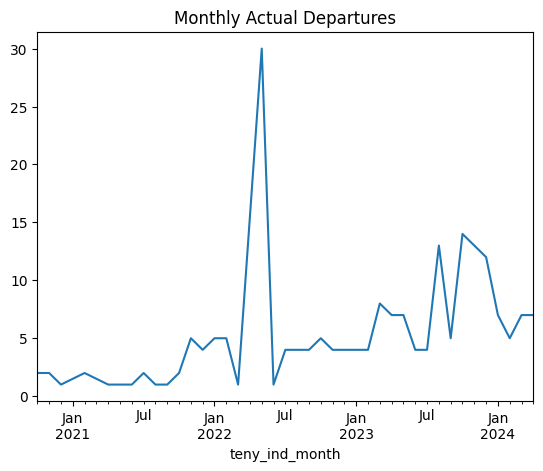

In [141]:
#Idősor elemzés
data_analysis['teny_ind_month'] = data_analysis['teny_ind'].dt.to_period('M')
monthly_departures = data_analysis.groupby('teny_ind_month').size()
monthly_departures.plot(kind='line', title='Monthly Actual Departures')

In [142]:
# Összehasonlító elemzés: terv vs teny
data_analysis['departure_delay'] = abs((data_analysis['teny_ind'] - data_analysis['terv_ind']).dt.total_seconds() / 60)  # in minutes
print(data_analysis['departure_delay'].describe())

count       200.000000
mean      20985.365000
std       59204.724243
min           0.000000
25%          59.750000
50%         137.000000
75%         541.000000
max      282292.000000
Name: departure_delay, dtype: float64


In [143]:
data_analysis[data_analysis["departure_delay"] > 50000]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny,teny_ind_month,departure_delay
110,2022-06-26 22:30:00,2022-06-26 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,6,26,22,30,0,25,2022,6,26,22,49,0,25,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,50452.0
111,2022-07-03 22:30:00,2022-03-07 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,3,22,30,0,26,2022,7,3,22,49,0,26,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,60532.0
112,2022-07-10 22:30:00,2022-10-07 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,10,22,30,0,27,2022,7,10,22,49,0,27,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,70612.0
113,2022-07-17 22:30:00,2022-07-17 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,17,22,30,0,28,2022,7,17,22,49,0,28,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,80692.0
114,2022-07-24 22:30:00,2022-07-24 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,24,22,30,0,29,2022,7,24,22,49,0,29,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,90772.0
115,2022-07-31 22:30:00,2022-07-31 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,31,22,30,0,30,2022,7,31,22,49,0,30,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,100852.0
116,2022-08-07 22:30:00,2022-07-08 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,7,22,30,0,31,2022,8,7,22,49,0,31,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,110932.0
117,2022-08-14 22:30:00,2022-08-14 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,14,22,30,0,32,2022,8,14,22,49,0,32,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,121012.0
118,2022-08-21 22:30:00,2022-08-21 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,21,22,30,0,33,2022,8,21,22,49,0,33,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,131092.0
119,2022-08-28 22:30:00,2022-08-28 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,28,22,30,0,34,2022,8,28,22,49,0,34,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,141172.0


In [144]:
# Compare scheduled and actual travel times
data_analysis['travel_time_difference'] = abs(data_analysis['travel_time_teny'] - data_analysis['travel_time_terv'])
print(data_analysis['travel_time_difference'].describe())

count     200.000000
mean      404.575000
std       461.055719
min         2.000000
25%        30.750000
50%       143.000000
75%       687.250000
max      1421.000000
Name: travel_time_difference, dtype: float64


In [145]:
# Correlation matrix for certain variables
correlation_matrix = data_analysis[['rakom_tom', 'vonathossz', 'travel_time_terv','travel_time_teny']].corr()
print(correlation_matrix)

                  rakom_tom  vonathossz  travel_time_terv  travel_time_teny
rakom_tom          1.000000    0.516777          0.017875         -0.058879
vonathossz         0.516777    1.000000          0.171116         -0.043113
travel_time_terv   0.017875    0.171116          1.000000          0.357295
travel_time_teny  -0.058879   -0.043113          0.357295          1.000000


In [146]:
# Analysis of train types and their frequencies
train_type_distribution = data_analysis['vonatnem'].value_counts()
print(train_type_distribution)

vonatnem
T     102
M      97
Gt      1
Name: count, dtype: int64


In [147]:
# Average actual travel time by train type
average_travel_time_by_type = data_analysis.groupby('vonatnem')['travel_time_teny'].mean()
print(average_travel_time_by_type)

vonatnem
Gt    813.000000
M     587.597938
T     399.460784
Name: travel_time_teny, dtype: float64


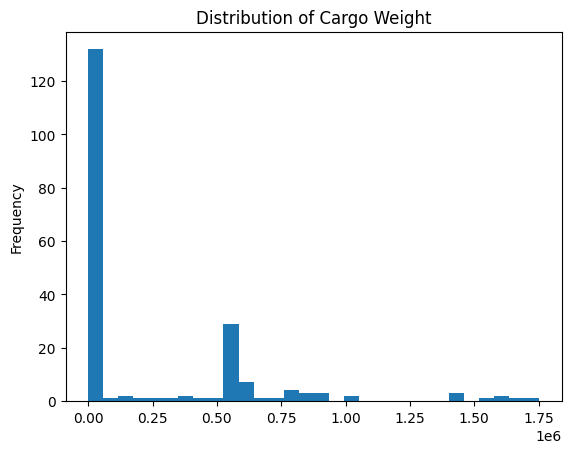

In [148]:
# Histogram for 'rakom_tom'
data_analysis['rakom_tom'].plot(kind='hist', bins=30, title='Distribution of Cargo Weight')
plt.show()

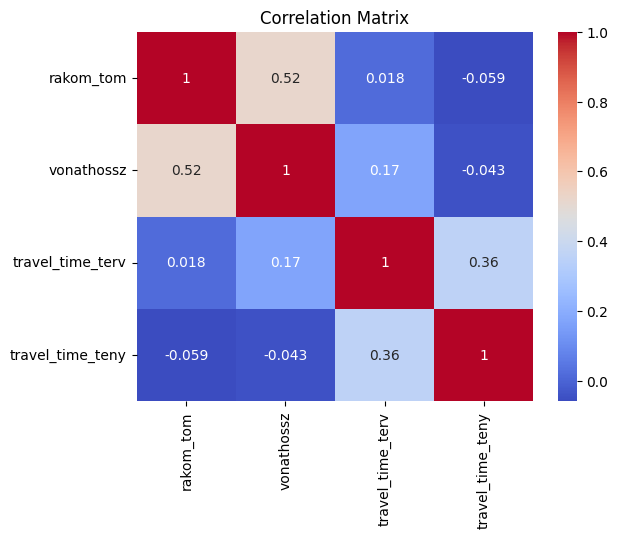

In [149]:
# Heat map for correlations
import seaborn as sns

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Normalizálás

In [150]:
dataset.drop('terv_ind', axis=1, inplace=True)
dataset.drop('terv_erk', axis=1, inplace=True)
dataset.drop('teny_ind', axis=1, inplace=True)
dataset.drop('teny_erk', axis=1, inplace=True)

In [151]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

OneHotEncoding


In [152]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-152-a4fce10cc6af>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
<ipython-input-152-a4fce10cc6af>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs[encoded_cols] = encoder.tr

In [153]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [154]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=4)

In [155]:
%%time
model.fit(X, targets)

CPU times: user 251 ms, sys: 2.89 ms, total: 254 ms
Wall time: 159 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [156]:
preds = model.predict(X)

In [157]:
def mse(a, b):
  return mean_squared_error(a, b, squared=True)

In [158]:
def mae(a, b):
  return mean_absolute_error(a,b)

In [159]:
xgbRegressorTrainMSE = mse(preds, targets)
xgbRegressorTrainMAE = mae(preds, targets)


print("mse (train): ",mse(preds, targets))
print("mae (train): ",mae(preds, targets))

preds_test = model.predict(X_test)

xgbRegressorTestMSE = mse(preds_test, y_test)
xgbRegressorTestMAE = mae(preds_test, y_test)

print("mse (train): ",mse(preds_test, y_test))
print("mae (train): ",mae(preds_test, y_test))

mse (train):  1014.1183102259704
mae (train):  24.494526304517475
mse (train):  204157.90477036164
mae (train):  301.00807126363117


In [160]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head()

,feature,importance
30,travel_time_terv,0.128241
70,ind_nev_terv_Soroksári út rendező,0.073301
19,teny_ind_Hour,0.064923
51,ind_nev_terv_Karcag,0.062605
183,erk_teny_Soroksár,0.053614


In [161]:
X = inputs[importance_df[importance_df.importance > 0.001].feature].copy()
X_test = test_inputs[importance_df[importance_df.importance > 0.001].feature].copy()

In [162]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=4)

In [163]:
%%time
model.fit(X, targets)

CPU times: user 98 ms, sys: 0 ns, total: 98 ms
Wall time: 60.5 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [164]:
preds = model.predict(X)

In [165]:
xgbRegressorImportantTrainMSE = mse(preds, targets)
xgbRegressorImportantTrainMAE = mae(preds, targets)

print("mse: ",mse(preds, targets))
print("mae: ",mae(preds, targets))

mse:  634.5855159455878
mae:  18.47702010018485


In [166]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head()

,feature,importance
3,ind_nev_terv_Karcag,0.087454
4,erk_teny_Soroksár,0.064467
5,terv_ind_Minute,0.061536
8,ind_nev_terv_Ferencv.Nyugati.r.,0.061428
13,terv_ind_Year,0.060689


In [167]:
def train_and_evaluateMSE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)
    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)
    return model, train_mse, val_mse

In [168]:
def train_and_evaluateMAE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)
    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)
    return model, train_mae, val_mae

In [169]:
kfold = KFold(n_splits=5)

In [170]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mse, val_mse = train_and_evaluateMSE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MSE: {}'.format(train_mse, val_mse))

Train MSE: 1621.2055132885846, Validation MSE: 431428.0545217227
Train MSE: 4571.2618602949215, Validation MSE: 234757.3245955646
Train MSE: 6266.384432299301, Validation MSE: 186157.9550275697
Train MSE: 6780.804540220268, Validation MSE: 162769.08100894318
Train MSE: 4834.177954026066, Validation MSE: 233891.19900967058


In [171]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mae, val_mae = train_and_evaluateMAE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MAE: {}'.format(train_mae, val_mae))

Train MSE: 29.56410962343216, Validation MAE: 480.16465704781666
Train MSE: 50.50727033615112, Validation MAE: 340.0570161002023
Train MSE: 58.428819979940144, Validation MAE: 309.03015981401717
Train MSE: 62.493112972804475, Validation MAE: 220.18550000871932
Train MSE: 50.03527511869158, Validation MAE: 380.9530527932303


In [172]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [173]:
preds = predict_avg(models, X_train)
preds

array([1024.2837  , 1198.1808  ,  462.98315 ,  799.24164 ,  208.99756 ,
        229.19919 , 1193.695   , 1152.6934  ,  968.9953  , 1033.5526  ,
        651.3349  ,  370.0029  ,  999.9549  ,   38.84526 , 1070.4811  ,
         38.566425,  760.82556 ,  249.63919 ,  371.7529  , 1165.1082  ,
       1126.9325  , 1166.3396  ,  119.347946,  960.6722  , 1044.1355  ,
         38.566425,  925.53595 , 1084.72    ,  325.05493 ,  437.73364 ,
        433.63657 ,  915.94824 ,  119.347946, 1126.8286  , 1389.1655  ,
         38.84526 ,   69.019516,  443.65186 ,  155.09903 ,  294.51648 ,
       1076.2942  ,   83.166214,   68.45628 , 1085.756   ,   38.566425,
        172.32484 ,  277.27814 ,  136.06955 ,  154.01463 ,  683.50354 ,
       1180.6218  ,  188.48117 ,  157.61276 ,   76.39702 , 1086.2013  ,
        835.5742  ,   38.566425,  317.94403 ,  301.1409  ,  328.79303 ,
        399.52496 ,  565.435   ,  227.2496  ,   78.31079 ,  130.70067 ,
         38.566425,  128.38448 ,  405.62344 , 1009.8109  ,  115.

In [174]:
drop_col = ["ind_nev_terv", "vontat_mode", "vonatnem", "ind_teny", "erk_teny"]
inputs.drop(drop_col, axis = 1, inplace = True)
test_inputs.drop(drop_col, axis = 1, inplace = True)


In [175]:
from sklearn.model_selection import RandomizedSearchCV


# ## Hyper Parameter Optimization
# n_estimators = [50, 75, 100, 200]
# max_depth = [2, 3, 5, 10, 15]
# learning_rate=[0.05,0.1,0.15,0.2]
# min_child_weight=[1,2,3,4]

# # Define the grid of hyperparameters to search
# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'max_depth':max_depth,
#     'learning_rate':learning_rate,
#     'min_child_weight':min_child_weight
#     }

# # Set up the random search with 4-fold cross validation
# random_cv = RandomizedSearchCV(estimator=model,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = 5,
#             verbose = 5,
#             return_train_score = True,
#             random_state=42)

# random_cv.fit(inputs,targets)

# print(random_cv.best_estimator_)

In [176]:
def train_and_evaluateMSE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)

    return model, train_mse, val_mse

In [177]:
def train_and_evaluateMAE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)
    model.fit(X_train, train_targets)

    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)

    return model, train_mae, val_mae

In [178]:
kfold = KFold(n_splits=5)
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mse, val_mse = train_and_evaluateMSE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MSE: {}'.format(train_mse, val_mse))

Train MSE: 2.0399361996429173e-07, Validation MSE: 511624.33007883746
Train MSE: 2.1053893663390356e-07, Validation MSE: 334222.88919513894
Train MSE: 1.9796168869236551e-07, Validation MSE: 292214.45498016017
Train MSE: 2.0373710997643813e-07, Validation MSE: 371445.88930915063
Train MSE: 1.8482381035158012e-07, Validation MSE: 431367.64589751087


In [179]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mae, val_mae = train_and_evaluateMAE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MAE: {}'.format(train_mae, val_mae))

Train MSE: 0.00035258701869419644, Validation MAE: 493.5248203958784
Train MSE: 0.00037730591637747627, Validation MAE: 393.98344435010637
Train MSE: 0.00035774707794189453, Validation MAE: 320.5697671345302
Train MSE: 0.0003572021211896624, Validation MAE: 386.6588611602783
Train MSE: 0.00036219188145228794, Validation MAE: 445.80612318856373


In [180]:
regressor = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

regressor.fit(inputs,targets)
y_pred = regressor.predict(test_inputs)

In [181]:
test_pred = regressor.predict(test_inputs)

xgbRegressorGsHptTestMSE = mse(test_pred, y_test)
xgbRegressorGsHptTestMAE =  mae(test_pred, y_test)

print("mse: ",mse(test_pred, y_test))
print("mae: ",mae(test_pred, y_test))

mse:  260702.02511869706
mae:  337.6668869654338


In [182]:
train_pred = regressor.predict(inputs)

xgbRegressorGsHptTrainMSE = mse(train_pred, targets)
xgbRegressorGsHptTrainMAE =  mae(train_pred, targets)

print("mse: ",mse(train_pred, targets))
print("mae: ",mae(train_pred, targets))

mse:  2.268533665171292e-07
mae:  0.00038943971906389507


In [183]:
test_targets_xgb = y_test
test_targets_xgb["test_pred"] = test_pred

#4377
idx = dataset_min_change.index.intersection(test_inputs.index)
print(idx)
dataset_min_changeXGB = dataset_min_change.loc[idx]
dataset_min_changeXGB["y_test"] = test_targets_xgb["travel_time_teny"]
dataset_min_changeXGB["predicted_travel_time"] = test_targets_xgb["test_pred"]
dataset_min_changeXGB.to_csv('submissionXGB.csv', index=None)

Index([  0,   3,   7,  10,  13,  15,  21,  25,  30,  32,  34,  42,  46,  47,
        49,  53,  61,  65,  70,  71,  74,  78,  83,  84,  86,  91,  92,  94,
        97,  98, 102, 105, 108, 110, 111, 115, 120, 121, 125, 129, 130, 132,
       139, 140, 142, 145, 150, 154, 159, 161, 162, 166, 167, 169, 173, 180,
       181, 183, 190, 191],
      dtype='int64')


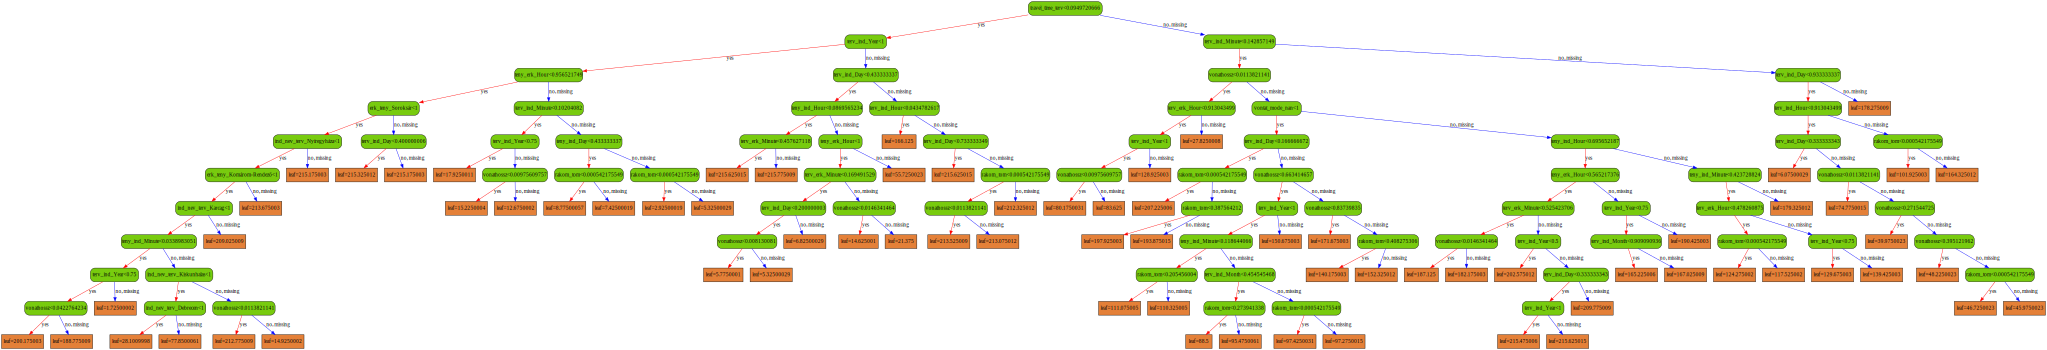

In [184]:
node_params = {
    'shape':'box',
    'style':'filled, rounded',
    'fillcolor':'#78cbe'
}
leaf_params = {
    'shape':'box',
    'style':'filled',
    'fillcolor':'#e48038'
}
image = xgb.to_graphviz(regressor, num_trees=0,size="1,1", condition_node_params=node_params, leaf_node_params=leaf_params)
image.graph_attr = {'dpi':'400'}
image.render('xgb_individualtree', format = 'png')
image

In [185]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

y_test.drop('test_pred', axis = 1, inplace = True)

model = RandomForestRegressor(random_state=1)
model.fit(inputs, targets)
predicted_values = model.predict(test_inputs)
predicted_valuesTrain = model.predict(inputs)

randomForestRegressorTrainMSE = metrics.mean_squared_error(targets, predicted_valuesTrain)
randomForestRegressorTrainMAE = metrics.mean_absolute_error(targets, predicted_valuesTrain)
randomForestRegressorTestMSE = metrics.mean_squared_error(y_test, predicted_values)
randomForestRegressorTestMAE = metrics.mean_absolute_error(y_test, predicted_values)

print("mean squared error (train): ",metrics.mean_squared_error(targets, predicted_valuesTrain))
print("mean squared error (test): ",metrics.mean_squared_error(y_test, predicted_values))
print("mean absolute error (train): ",metrics.mean_absolute_error(targets, predicted_valuesTrain))
print("mean absolute error (test): ",metrics.mean_absolute_error(y_test, predicted_values))

<ipython-input-185-8733fe88dc6c>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(inputs, targets)


mean squared error (train):  27496.994425
mean squared error (test):  176701.31364333333
mean absolute error (train):  119.51050000000001
mean absolute error (test):  279.85300000000007


In [186]:
predicted_values

array([  36.01,   36.  ,   36.  ,  807.68,  355.65,  205.22,  998.25,
        279.14,  271.44,  889.26,  832.49,  199.99,  153.64, 1067.25,
         36.  ,   36.  ,   56.72,  415.53,  104.02,  489.21,   49.92,
        159.92,  176.9 ,  561.43,  708.16,   36.  ,  477.28,  494.3 ,
        225.07,   36.  ,  918.73,  657.58,  661.37,  621.21,  970.07,
        848.65,  307.77,   36.  ,  687.21,  423.95,  450.44,   56.99,
        807.96,  207.71,  929.41,   36.  ,  347.18,   36.13,  549.69,
        984.42, 1029.63,  652.86,  796.05,  291.57,  299.34,  214.88,
        487.87,  487.63,  581.53,  300.29])

In [187]:
test_targets = y_test
test_targets["predicted_values"] = predicted_values
test_targets

,travel_time_teny,predicted_values
132,36,36.01
129,36,36.00
121,36,36.00
53,999,807.68
183,46,355.65
0,1430,205.22
34,615,998.25
97,500,279.14
92,1032,271.44
15,890,889.26


In [188]:
dataset_min_change

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
0,2021-04-11 11:00:00,2021-04-11 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7


In [189]:
#4525
idx = dataset_min_change.index.intersection(test_inputs.index)
print(idx)

Index([  0,   3,   7,  10,  13,  15,  21,  25,  30,  32,  34,  42,  46,  47,
        49,  53,  61,  65,  70,  71,  74,  78,  83,  84,  86,  91,  92,  94,
        97,  98, 102, 105, 108, 110, 111, 115, 120, 121, 125, 129, 130, 132,
       139, 140, 142, 145, 150, 154, 159, 161, 162, 166, 167, 169, 173, 180,
       181, 183, 190, 191],
      dtype='int64')


In [190]:
dataset_min_change = dataset_min_change.loc[idx]

In [191]:
dataset_min_change["y_test"] = test_targets["travel_time_teny"]
dataset_min_change["predicted_travel_time"] = test_targets["predicted_values"]

In [192]:
dataset_min_change

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,y_test,predicted_travel_time
0,2021-04-11 11:00:00,2021-04-11 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14,1430,205.22
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51,954,918.73
7,2022-11-15 01:00:00,2022-11-15 01:54:00,Kiskunhalas,Kiskunfélegyháza,2022-11-15 09:02:00,2022-11-15 08:07:00,0,21,NaN,M,Kiskunhalas,Kiskunfélegyháza,2022,11,15,1,0,0,46,2022,11,15,1,54,0,46,2022,11,15,9,2,0,46,2022,11,15,8,7,0,46,1385,415.53
10,2023-11-23 20:53:00,2023-11-23 23:44:00,Tatabánya,Dunakeszi,2023-11-23 21:14:00,2023-11-24 17:56:00,1584060,407,tmDieselVillany,T,Tatabánya,Dunakeszi,2023,11,23,20,53,0,47,2023,11,23,23,44,0,47,2023,11,23,21,14,0,47,2023,11,24,17,56,0,47,1242,657.58
13,2023-05-04 08:00:00,2023-05-04 08:26:00,Nagykanizsa,Gyékényes,2023-05-04 07:20:00,2023-05-04 07:00:00,0,17,NaN,M,Nagykanizsa,Gyékényes,2023,5,4,8,0,0,18,2023,5,4,8,26,0,18,2023,5,4,7,20,0,18,2023,5,4,7,0,0,18,1420,159.92
15,2023-10-20 01:00:00,2023-10-20 04:28:00,Szolnok-Rendező,Dombóvár,2023-10-19 22:30:00,2023-10-20 13:20:00,0,20,NaN,M,Szolnok-Rendező,Dombóvár,2023,10,20,1,0,0,42,2023,10,20,4,28,0,42,2023,10,19,22,30,0,42,2023,10,20,13,20,0,42,890,889.26
21,2024-01-20 01:00:00,2024-01-20 01:14:00,Soroksár-Terminál,Ferencváros,2024-01-20 00:15:00,2024-01-20 06:30:00,0,21,NaN,M,Soroksár-Terminál,Ferencváros,2024,1,20,1,0,0,3,2024,1,20,1,14,0,3,2024,1,20,0,15,0,3,2024,1,20,6,30,0,3,375,1067.25
25,2024-04-11 08:50:00,2024-04-11 09:19:00,Ferencv.Nyugati.r.,Soroksár-Terminál,2024-04-11 08:29:00,2024-04-11 19:00:00,0,30,NaN,T,Ferencv.Nyugati.r.,Soroksár-Terminál,2024,4,11,8,50,0,15,2024,4,11,9,19,0,15,2024,4,11,8,29,0,15,2024,4,11,19,0,0,15,631,487.63
30,2022-01-24 23:00:00,2022-01-24 00:30:00,Siófok-Teher,Uzsa,2022-01-24 18:58:00,2022-01-25 06:15:00,0,19,tmDiesel,M,Siófok-Teher,Uzsa,2022,1,24,23,0,0,4,2022,1,24,0,30,0,4,2022,1,24,18,58,0,4,2022,1,25,6,15,0,4,677,621.21
32,2022-02-22 23:50:00,2022-02-22 02:47:00,Kiskunfélegyháza,Békéscsaba,2022-02-23 02:10:00,2022-02-23 01:50:00,0,32,NaN,T,Kiskunfélegyháza,Békéscsaba,2022,2,22,23,50,0,8,2022,2,22,2,47,0,8,2022,2,23,2,10,0,8,2022,2,23,1,50,0,8,1420,708.16


In [193]:
dataset_min_change.columns

Index(['terv_ind', 'terv_erk', 'ind_nev_terv', 'erk__terv', 'teny_ind',
       'teny_erk', 'rakom_tom', 'vonathossz', 'vontat_mode', 'vonatnem',
       'ind_teny', 'erk_teny', 'terv_ind_Year', 'terv_ind_Month',
       'terv_ind_Day', 'terv_ind_Hour', 'terv_ind_Minute', 'terv_ind_Second',
       'terv_ind_WeekOfYear', 'terv_erk_Year', 'terv_erk_Month',
       'terv_erk_Day', 'terv_erk_Hour', 'terv_erk_Minute', 'terv_erk_Second',
       'terv_erk_WeekOfYear', 'teny_ind_Year', 'teny_ind_Month',
       'teny_ind_Day', 'teny_ind_Hour', 'teny_ind_Minute', 'teny_ind_Second',
       'teny_ind_WeekOfYear', 'teny_erk_Year', 'teny_erk_Month',
       'teny_erk_Day', 'teny_erk_Hour', 'teny_erk_Minute', 'teny_erk_Second',
       'teny_erk_WeekOfYear', 'y_test', 'predicted_travel_time'],
      dtype='object')

In [194]:
dataset_min_change.to_csv('submissionRFR.csv', index=None)

In [195]:
parameters = {
    'n_estimators': [50,100,150,200],
    'max_depth': [item for item in range(3, 15+1)]
}

In [196]:
#inputs = x_train
#targets = y_train
#test_inputs = x_test
from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(model, parameters)
# gs  = clf.fit(inputs, targets.values.ravel())
# print(gs.best_params_)

In [197]:
model = RandomForestRegressor(random_state=1, max_depth=15, n_estimators=200)
model.fit(inputs, targets)

<ipython-input-197-39e41942ea37>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(inputs, targets)


RandomForestRegressor(max_depth=15, n_estimators=200, random_state=1)

In [198]:
y_pred_train = model.predict(inputs)

randomForestRegressorGsHptTrainMSE = metrics.mean_squared_error(targets, y_pred_train)
randomForestRegressorGsHptTrainMAE = metrics.mean_absolute_error(targets, y_pred_train)

print("mse: ",metrics.mean_squared_error(targets, y_pred_train))
print("mae: ",metrics.mean_absolute_error(targets, y_pred_train))

mse:  27383.47241797327
mae:  119.20630229716984


In [199]:
y_test.drop('travel_time_teny', axis=1, inplace=True)
y_pred = model.predict(test_inputs)


randomForestRegressorGsHptTestMSE = metrics.mean_squared_error(y_test, y_pred)
randomForestRegressorGsHptTestMAE = metrics.mean_absolute_error(y_test, y_pred)

print("mse: ",metrics.mean_squared_error(y_test, y_pred))
print("mae: ",metrics.mean_absolute_error(y_test, y_pred))


mse:  507.17884901593806
mae:  16.306062958551387


In [200]:
print(y_test)

     predicted_values
132             36.01
129             36.00
121             36.00
53             807.68
183            355.65
0              205.22
34             998.25
97             279.14
92             271.44
15             889.26
94             832.49
154            199.99
161            153.64
21            1067.25
125             36.00
111             36.00
145             56.72
7              415.53
159            104.02
139            489.21
115             49.92
13             159.92
190            176.90
167            561.43
32             708.16
108             36.00
83             477.28
70             494.30
150            225.07
110             36.00
3              918.73
10             657.58
71             661.37
30             621.21
91             970.07
65             848.65
49             307.77
130             36.00
74             687.21
181            423.95
86             450.44
142             56.99
166            807.96
191            207.71
98        

In [201]:
dataset[numeric_cols] = scaler.transform(dataset[numeric_cols])

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(dataset[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
dataset[encoded_cols] = encoder.transform(dataset[categorical_cols])
X_test = dataset[numeric_cols + encoded_cols]
clf = model.fit(X_test, y)
all_pred = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-201-432563adf575>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[encoded_cols] = encoder.transform(dataset[categorical_cols])
<ipython-input-201-432563adf575>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[encoded_cols] = encoder

In [202]:
randomForestTreeGsHptAllMSE =  metrics.mean_squared_error(y, all_pred)
randomForestTreeGsHptAllMAE =  metrics.mean_absolute_error(y, all_pred)
print("mse: ",metrics.mean_squared_error(y, all_pred))
print("mae: ",metrics.mean_absolute_error(y, all_pred))

mse:  27057.99850676833
mae:  117.67299716653301


Összegezve: modellek teljesítménye

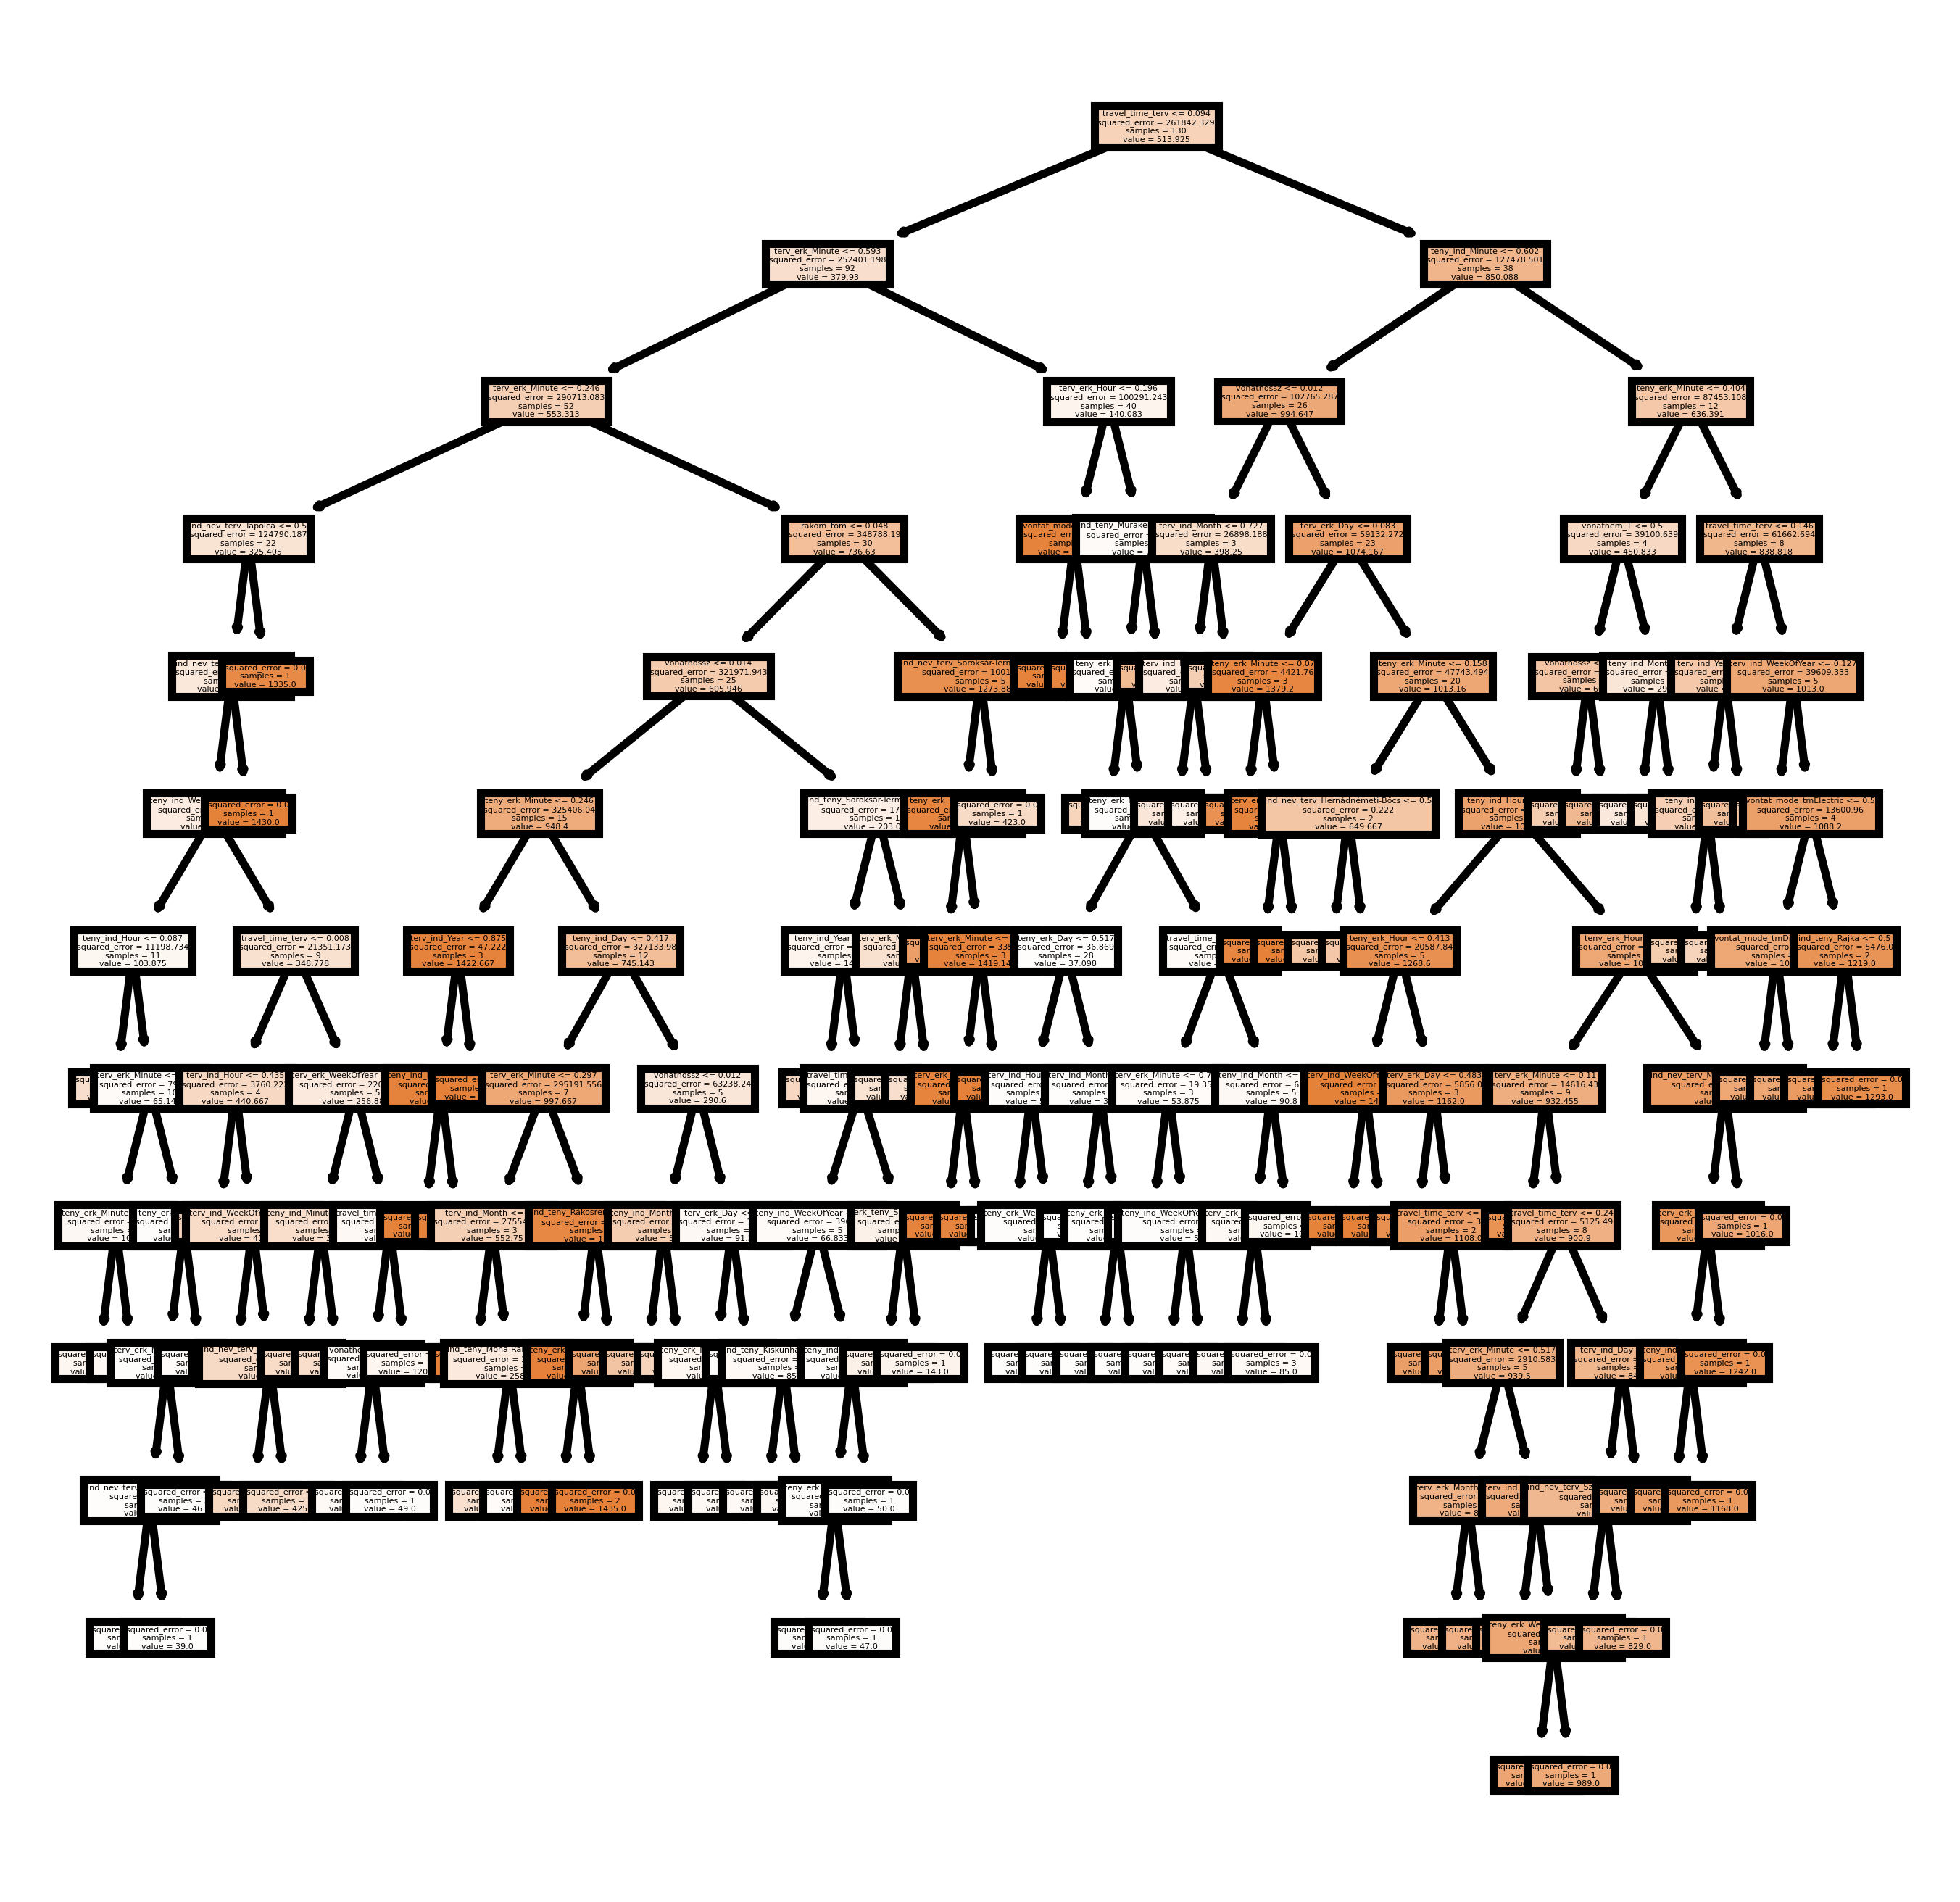

In [203]:
from sklearn import tree
fn=X_test.columns
cn=y.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(model.estimators_[0],
               feature_names = fn,
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

In [204]:

print("tanuló adatokra XGBRegressor")
print("mse: ",xgbRegressorTrainMSE)
print("mae: ",xgbRegressorTrainMAE)

print("\n")

print("teszt adatokra XGBRegressor")
print("mse: ",xgbRegressorTestMSE)
print("mae: ",xgbRegressorTestMAE)

print("\n")

print("tanuló adatokra XGBRegressor fontosabb oszlopai")
print("mse: ",xgbRegressorImportantTrainMSE)
print("mae: ",xgbRegressorImportantTrainMAE)

print("\n")

print("tanuló adatokra XGBRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",xgbRegressorGsHptTrainMSE)
print("mae: ",xgbRegressorGsHptTrainMAE)

print("\n")

print("teszt adatokra XGBRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",xgbRegressorGsHptTestMSE)
print("mae: ",xgbRegressorGsHptTestMAE)

print("\n")

print("tanuló adatokra RandomForestRegressor")
print("mse: ",randomForestRegressorTrainMSE)
print("mae: ",randomForestRegressorTrainMSE)

print("\n")

print("teszt adatokra RandomForestRegressor")
print("mse: ",randomForestRegressorTestMSE)
print("mae: ",randomForestRegressorTestMAE)

print("\n")

print("tanuló adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestRegressorGsHptTrainMSE)
print("mae: ",randomForestRegressorGsHptTrainMAE)

print("\n")

print("teszt adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestRegressorGsHptTestMSE)
print("mae: ",randomForestRegressorGsHptTestMAE)

print("\n")

print("Az összes adatra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestTreeGsHptAllMSE)
print("mae: ",randomForestTreeGsHptAllMAE)

tanuló adatokra XGBRegressor
mse:  1014.1183102259704
mae:  24.494526304517475


teszt adatokra XGBRegressor
mse:  204157.90477036164
mae:  301.00807126363117


tanuló adatokra XGBRegressor fontosabb oszlopai
mse:  634.5855159455878
mae:  18.47702010018485


tanuló adatokra XGBRegressor + GridSearch + Hyperparameter tunning
mse:  2.268533665171292e-07
mae:  0.00038943971906389507


teszt adatokra XGBRegressor + GridSearch + Hyperparameter tunning
mse:  260702.02511869706
mae:  337.6668869654338


tanuló adatokra RandomForestRegressor
mse:  27496.994425
mae:  27496.994425


teszt adatokra RandomForestRegressor
mse:  176701.31364333333
mae:  279.85300000000007


tanuló adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning
mse:  27383.47241797327
mae:  119.20630229716984


teszt adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning
mse:  507.17884901593806
mae:  16.306062958551387


Az összes adatra RandomForestRegressor + GridSearch + Hyperparameter tunning
